Create a dataframe with retrieve Tweets from 2022-23

In [1]:
import pandas as pd
import json

# read the JSONL file
with open('data/activity_congress.jsonl', 'r', encoding='utf8') as f:
    lines = f.readlines()

# convert each JSON object to a dictionary and store in a list
data = []
for line in lines:
    data.append(json.loads(line))

# create a dataframe from the list of dictionaries
df = pd.DataFrame(data)


In [4]:
tweets = []
for tweet in df['data']:
    for t in tweet:
        tweet_dict = {}
        tweet_dict['user_id'] = t['author_id']
        tweet_dict['text'] = t['text']
        tweet_dict['created_at'] = t['created_at']
        tweets.append(tweet_dict)

df_tweets = pd.DataFrame(tweets)

In [37]:
df_tweets.to_csv('tweets_congress.csv', index=False)

Convert to word embedded vectors using SBERT. Generate K clusters. Each cluster ‘motive’ is a node

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

tweets = pd.read_csv('tweets_congress.csv')


In [2]:
import preproc_functions as preproc
# apply standard preprocessing
tweets['pp_text'] = tweets['text'].apply(preproc.preprocess_text)
#add stopwords that occur once in in >=50% of documents
tweets = preproc.remove_common_words(tweets, 'pp_text', 'user_id', threshold=0.5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ghias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ghias\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
embeddings = model.encode(tweets['pp_text'])

In [4]:
import pandas as pd
from scipy.cluster.vq import kmeans, vq

# cluster the embeddings
k = 12
centroids, distortion = kmeans(embeddings, k)
clusters, _ = vq(embeddings, centroids)

# Assign each tweet to its corresponding cluster
tweets['cluster'] = clusters

In [5]:
tweets

,user_id,text,created_at,pp_text,cluster
0,10615232,Serving the ppl of Iowa is my top priority As ...,2022-12-31T21:09:38.000Z,serv ppl iowa top prioriti rank member senat j...,8
1,10615232,EPA is again trying to expand the definition o...,2022-12-30T19:54:56.000Z,epa tri expand definit water u amp ad red tape...,8
2,10615232,❤️ https://t.co/JkKusr99i1,2022-12-30T15:56:13.000Z,httpstcojkkusri,5
3,10615232,Drug traffickers are targeting teens &amp; you...,2022-12-30T15:40:47.000Z,drug traffick target teen amp young adult beef...,2
4,10615232,My Stop Pills That Kill Act requires the DEA t...,2022-12-30T15:37:41.000Z,stop pill kill act requir dea creat comprehens...,7
...,...,...,...,...,...
30578,11651202,"RT @GovGianforte: This January, we rolled up o...",2022-01-01T01:10:26.000Z,rt govgianfort januari roll sleev got work lea...,6
30579,41702856,@PatriciaElsa7 @AdrianzenEduard Y el estaciona...,2022-12-24T23:29:46.000Z,patriciaelsa adrianzeneduard el estacionamient...,1
30580,41702856,RT @DeltaMdelta: #EstadoDeEmergencia ¿Que impl...,2022-12-14T19:36:05.000Z,rt deltamdelta estadodeemergencia que implica ...,1
30581,41702856,@ArbildoEna @PennyMontenegro Dios cuide a su h...,2022-12-14T16:56:49.000Z,arbildoena pennymontenegro dio cuid su hijo lo...,0


In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k = 12
kmeans_model = KMeans(n_clusters=k, random_state=42)
kmeans_model.fit(embeddings)

# calculate silhouette score
silhouette_avg = silhouette_score(embeddings, kmeans_model.labels_)
print("Silhouette Score:", silhouette_avg)

# calculate within-cluster sum of squares (WSS)
wss = kmeans_model.inertia_
print("Within-cluster sum of squares (WSS):", wss)


C:\Users\ghias\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.047501944
Within-cluster sum of squares (WSS): 2867385.75


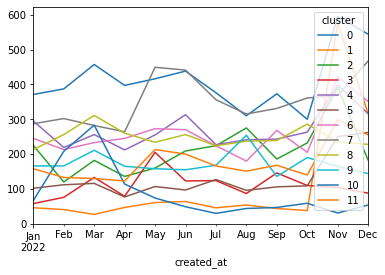

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# assume your dataframe is named 'df'
# step 1
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

# step 2
tweets.set_index('created_at', inplace=True)

# step 3 and 4
counts = tweets.groupby('cluster').resample('M').count()

# step 5
counts = counts['user_id'].unstack('cluster')

# step 6
counts.plot(kind='line')
plt.show()


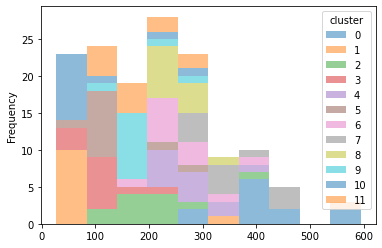

In [7]:
counts.plot(kind='hist', stacked=True, alpha=0.5, bins=10)
plt.show()

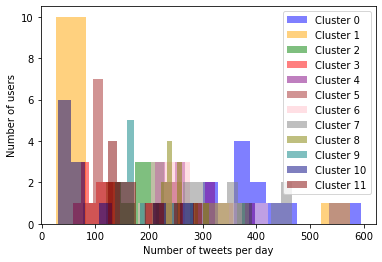

In [9]:
# step 6
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'teal', 'navy', 'maroon']
for i, col in enumerate(counts.columns):
    plt.hist(counts[col], bins=10, alpha=0.5, label=f'Cluster {col}', color=colors[i])

plt.legend()
plt.xlabel('Number of tweets per day')
plt.ylabel('Number of users')
plt.show()

Using text mining techniques such as topic modeling to automatically identify the main topics in each cluster.

In [69]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# create a bag-of-words representation of the text data
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(tweets['pp_text'])

# set the number of topics
n_topics = 6

# train an LDA model
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# get the topic probabilities for each document
doc_topic_probs = lda.transform(X)

# print the top words for each topic
topics = []
for topic_idx, topic in enumerate(lda.components_):
    top_words = []
    for i in range(len(vectorizer.vocabulary_)):
        if vectorizer.vocabulary_[list(vectorizer.vocabulary_.keys())[i]] == topic.argsort()[:-len(vectorizer.vocabulary_)-1:-1][0]:
            top_words.append(list(vectorizer.vocabulary_.keys())[i])
    topics.append(top_words)

# assign the main topic to each tweet
main_topic = []
for i in range(len(doc_topic_probs)):
    topic_probs = doc_topic_probs[i]
    main_topic_idx = np.argmax(topic_probs)
    main_topic.append(topics[main_topic_idx][0] if topics[main_topic_idx] else "")

# add the main topic column to the tweets dataframe
tweets['main_topic_6.1'] = main_topic

topics_6 = topics.copy()

In [80]:
# from gensim.models.ldamodel import LdaModel
# from gensim.corpora.dictionary import Dictionary
# from gensim.models.coherencemodel import CoherenceModel
# from nltk.tokenize import RegexpTokenizer
# from nltk.corpus import stopwords
# import pandas as pd

# # create a dictionary and bag-of-words representation of the text data
# texts = [tweet.split() for tweet in tweets['pp_text']]
# dictionary = Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # set the number of topics
# n_topics = 12

# # assign the topics

# dictionary.add_documents(texts)

# # train an LDA model
# lda = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)

# # get the topic probabilities for each document
# doc_topic_probs = lda.get_document_topics(corpus)

# # print the top words for each topic
# topics = lda.show_topics(num_topics=n_topics, num_words=10)

# # assign the main topic to each tweet
# main_topic = []
# for i, doc in enumerate(doc_topic_probs):
#     main_topic_idx = max(doc, key=lambda x: x[1])[0]
#     main_topic.append(main_topic_idx)

# # add the main topic column to the tweets dataframe
# tweets['main_topic_6.2'] = main_topic

# # calculate the topic coherence score for the LDA model
# coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print("Topic Coherence Score (LDA):", coherence_lda)

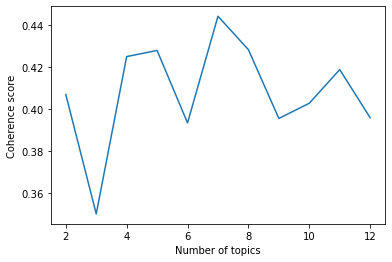

In [78]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt

# create a dictionary and bag-of-words representation of the text data
texts = [tweet.split() for tweet in tweets['pp_text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# define the range of topics to explore
start_topic = 2
end_topic = 12

# initialize variables to store coherence scores and main topics
coherence_scores = []
main_topics = []

# iterate through different number of topics
for n_topics in range(start_topic, end_topic+1):

    # train an LDA model
    lda = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)

    # get the topic probabilities for each document
    doc_topic_probs = lda.get_document_topics(corpus)

    # assign the main topic to each tweet
    main_topic = []
    for i, doc in enumerate(doc_topic_probs):
        main_topic_idx = max(doc, key=lambda x: x[1])[0]
        main_topic.append(main_topic_idx)

    # add the main topic column to the tweets dataframe
    tweets[f'main_topic_{n_topics}'] = main_topic

    # calculate the topic coherence score for the LDA model
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    # append coherence score and main topic to lists
    coherence_scores.append(coherence_lda)
    main_topics.append(n_topics)

# plot coherence score vs number of topics
plt.plot(main_topics, coherence_scores)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.show()

In [75]:
#tweets = tweets.drop(columns=['main_topic_6.1', 'main_topic_6.2'])

In [81]:
tweets.columns

Index(['user_id', 'text', 'pp_text', 'cluster', 'main_topic_6.2', 'main_topic',
       'main_topic_2', 'main_topic_3', 'main_topic_4', 'main_topic_5',
       'main_topic_6', 'main_topic_7', 'main_topic_8', 'main_topic_9',
       'main_topic_10', 'main_topic_11', 'main_topic_12'],
      dtype='object')